# Manifold Learning

Manifold learning is an approach to non-linear dimensionality reduction. Algorithms for this task are based on the idea that the dimensionality of many data sets is only artificially high. Recall, how principal component analysis (PCA) can be used in the dimensionality reduction task—reducing the number of features of a dataset while maintaining the essential relationships between the points. While PCA is flexible, fast, and easily interpretable, it does not perform so well when there are nonlinear relationships within the data.

To address this deficiency, we can turn to a class of methods known as manifold learning—a class of unsupervised estimators that seeks to describe datasets as low-dimensional manifolds embedded in high-dimensional spaces. While thinking of the manifold, consider a sheet of paper: this is a two-dimensional object that lives in our familiar three-dimensional world, and can be bent or rolled in that two dimensions. In the parlance of manifold learning, we can think of this sheet as a two-dimensional manifold embedded in three-dimensional space.

Rotating, re-orienting, or stretching the piece of paper in three-dimensional space doesn't change the flat geometry of the paper: such operations are akin to linear embeddings. If you bend, curl, or crumple the paper, it is still a two-dimensional manifold, but the embedding into the three-dimensional space is no longer linear. Manifold learning algorithms would seek to learn about the fundamental two-dimensional nature of the paper, even as it is contorted to fill the three-dimensional space.

In this notebook, we will demonstrate a number of manifold methods: multidimensional scaling (MDS), locally linear embedding (LLE), and isometric mapping (IsoMap).

We begin by standard imports.

In [1]:
'''
Import required libraries
'''

# %matplotlib notebook

import matplotlib.pyplot as plt
# import seaborn as sns; sns.set()
import numpy as np

### Generating data

We will first generate some two dimensional data that we can use to define a manifold. In what follows, we will create data in the shape of a word . This data will help us to see visually what these algorithms are doing.

In [2]:
'''
Function to generate some two dimensional data
'''

def make_data(N=1000, rseed=42):
    # Make a plot with some text; save as PNG
    fig, ax = plt.subplots(figsize=(4, 1))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
    ax.axis('off')
    ax.text(0.5, 0.4, 'neil', va='center', ha='center', weight='bold', size=85)
    fig.savefig('data.png')
    plt.close(fig)
    
    # Open this PNG and draw random points from it
    from matplotlib.image import imread
    data = imread('data.png')[::-1, :, 0].T
    rng = np.random.RandomState(rseed)
    X = rng.rand(4 * N, 2) #Random values in a given shape.
    i, j = (X * data.shape).astype(int).T
    mask = (data[i, j] < 1)
    X = X[mask]
    X[:, 0] *= (data.shape[0] / data.shape[1])
    X = X[:N]
    return X[np.argsort(X[:, 0])]

(1000, 2) (1000,)


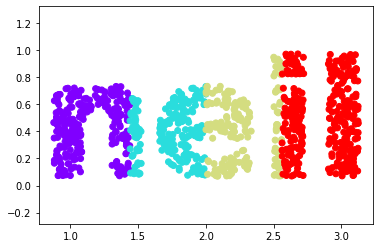

In [3]:
'''
Generate data and plot it
'''

# Generate data with 1000 points
X = make_data(1000) 
print(X.shape, X[:, 0].shape)
colorize = dict(c=X[:, 0], cmap=plt.cm.get_cmap('rainbow', 4))

# Plot the data
fig = plt.figure()
plt.scatter(X[:, 0], X[:, 1], **colorize)
plt.axis('equal');

## Motivation

Looking at data like this, we can see that the particular choice of $x$ and $y$ values of the dataset are not the most fundamental description of the data: we can scale, shrink, or rotate the data, and the word will still be apparent. For example, if we use a rotation matrix to rotate the data, the x and y values change, but the data is still fundamentally the same:

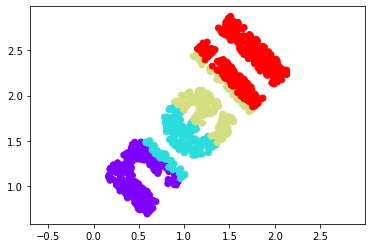

In [4]:
'''
Rotate the data and plot it
'''

# Function to rotate and translate the data by a certain angle
def rotate(X, angle):
    theta = np.deg2rad(angle)
    R = [[np.cos(theta), np.sin(theta)],
         [-np.sin(theta), np.cos(theta)]]
    return np.dot(X, R)
    
X2 = rotate(X, 45) 

# Plot the data
fig = plt.figure()
plt.scatter(X2[:, 0], X2[:, 1], **colorize)
plt.axis('equal');

This tells us that the $x$ and $y$ values are not necessarily fundamental to the relationships in the data. What is fundamental, in this case, is the distance between each point and the other points in the dataset. A common way to represent this is to use a distance matrix: for $N$ points, we construct an $N \times N$ array such that entry $(i, j)$ contains the distance between point $i$ and point $j$. Let's use Scikit-Learn's efficient pairwise_distances function to do this for our original data:

Shape: (1000, 1000)


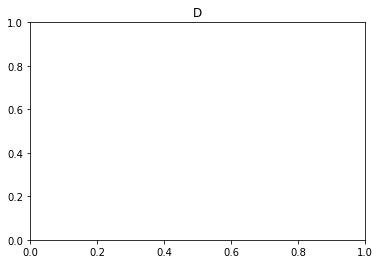

In [5]:
'''
Compute the pairwise distances between the points in the data
'''
from sklearn.metrics import pairwise_distances

D = pairwise_distances(X)
plt.title('D') 
print('Shape:', D.shape)

As promised, for our $N=1,000$ points, we obtain a $1000 \times 1000$ matrix, which can be visualized as shown here:

If we similarly construct a distance matrix for our rotated and translated data, we see that it is the same:

In [6]:
# Compute pairwise distance for the rotated and translated data
D2 = pairwise_distances(X2)

# Check if both matrices are equal to each other
print(np.allclose(D, D2))

True


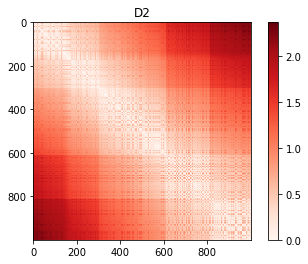

In [7]:
fig = plt.figure()

plt.imshow(D2, zorder=2, cmap='Reds', interpolation='nearest')
plt.title('D2') 
plt.colorbar();

This distance matrix gives us a representation of our data that is invariant to rotations and translations, but the visualization of the matrix above is not entirely intuitive. In the representation shown in this figure, we have lost any visible sign of the interesting structure in the data: the word that we saw before.

We will now generalize on this idea and consider hte fact that distance matrices can be computed from data in any dimension. So, for example, instead of simply rotating the data in the two-dimensional plane, we can project it into three dimensions using the following function (essentially a three-dimensional generalization of the rotation matrix used earlier) and visualize it:

(1000, 3)


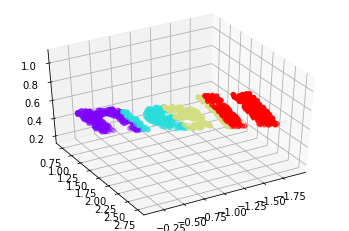

In [8]:
'''
Project the 2D data in higher dimensions (here 3) and visualize it
'''

# Function to project data into higher dimensions
def random_projection(X, dimension=3, rseed=42):
    assert dimension >= X.shape[1]
    rng = np.random.RandomState(rseed)
    C = rng.randn(dimension, dimension)
    e, V = np.linalg.eigh(np.dot(C, C.T))
    return np.dot(X, V[:X.shape[1]])
    
X3 = random_projection(X, 3)
print(X3.shape)

# Plot the higher dimensional data
from mpl_toolkits import mplot3d

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(X3[:, 0], X3[:, 1], X3[:, 2],
             **colorize)
ax.view_init(azim=60, elev=40)

We see that by simply projecting the data into higher dimensions, no new information is being added. Conversely, this 3-dimensional data lies in a lower dimensional manifold which we want to recover. Indeed, the pairwise distance between the points is preserved as shown below.

In [9]:
'''
Check if pairwise distance between the 2D data and the 3D data are the same
'''

D3 = pairwise_distances(X3)
print(np.allclose(D3, D2))

True


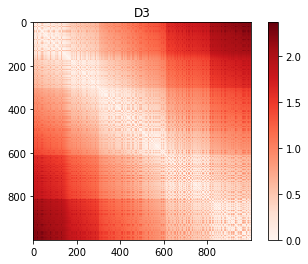

In [10]:
fig = plt.figure()

plt.imshow(D3, zorder=2, cmap='Reds', interpolation='nearest')
plt.title('D3') 
plt.colorbar();

Further, while computing this distance matrix from the (x, y) coordinates is straightforward, transforming the distances back into x and y coordinates is rather difficult. This is exactly what the multidimensional scaling algorithm aims to do: given a distance matrix between points, it recovers a $D$-dimensional coordinate representation of the data. 

## 1. Multidimensional Scaling for Manifold Learning

In this section, we will implement a MDS function, which can take input this 3-dimensional data, compute the distance matrix, and then determine the optimal 2-dimensional embedding for the distance matrix. We will employ MDS implemented in the scikit learn manifold package.

__Multidimensional Scaling (MDS)__ is an algorithm used for dimensionality reduction, and most often used to visualize the similarities in the dataset. MDS uses pairwise similarity measures (which can be similarity measures of any kind, even qualitative ratings of similarity) to construct a spatial representation that keeps similar objects close together and dissimilar objects further apart. In this way, the goal is to capture the structure of the higher dimensional data in a lower dimensional representation.

MDS differs from many other dimensionality reduction methods in that the input to MDS is only the dissimilarity matrix, instead of the actual position vectors of the data. Given a pairwise dissimilarity matrix $D$ with entries $d_{ij}$ for the distance/dissimilarity between observations $i$ and $j$, we find $x_1, ..., x_n \in \mathbb{R}^k$ such that:
$$\underbrace{d_{i,j}^2}_{\text{original distances}} \approx \underbrace{||x_i - x_j||^2}_{\text{output configuration}} $$
We find a configuration (typically a lower dimensional configuration in $\mathbb{R}^2$) that keeps the Euclidean distances in $\mathbb{R}^k$ as close as possible to our original distances/similarities.

In [11]:
from sklearn.manifold import MDS
# define the MDS model
#Number of dimensions in which to immerse the dissimilarities.: n_comp
#max_iter Maximum number of iterations of the SMACOF algorithm for a single run.
#n_init : number of times the SMACOF algorithm will be run with different initializations. 
import time
def experiment(iters, inits):
    start = time.time()
    model = MDS(n_components=2, random_state=1, verbose = 1, max_iter = iters, n_init=inits) 
    # fit the model on the data (X3)
    out3 = model.fit_transform(X3)
    end = time.time()
    fig = plt.figure()
    plt.scatter(out3[:, 0], out3[:, 1], **colorize)
    plt.title("iterations: {} initializations: {} time: {}sec".format(iters,inits,end-start))
    plt.axis('equal');

breaking at iteration 76 with stress 1.715205703149083


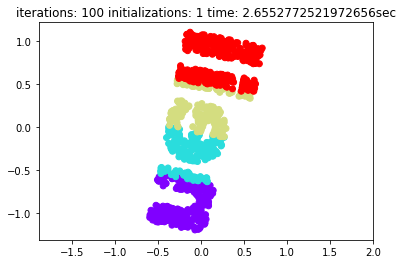

In [12]:
experiment(100,1) #good

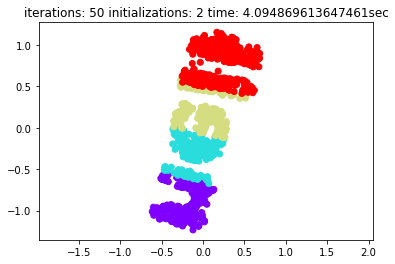

In [13]:
experiment(50,2)

breaking at iteration 76 with stress 1.715205703149083


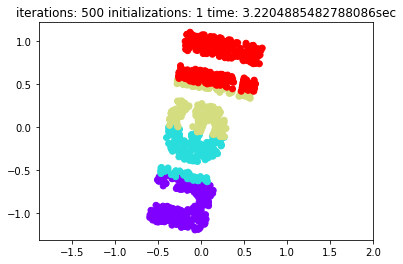

In [14]:
experiment(500,1) #best

breaking at iteration 76 with stress 1.715205703149083
breaking at iteration 94 with stress 1.0404177791228706
breaking at iteration 98 with stress 1123.6300525175643
breaking at iteration 64 with stress 1.8391752617190111


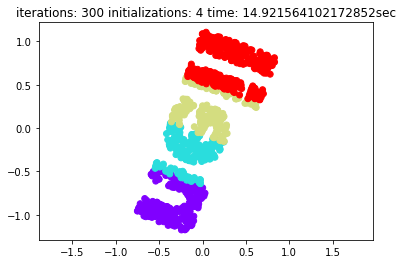

In [15]:
experiment(300,4)

breaking at iteration 76 with stress 1.715205703149083
breaking at iteration 94 with stress 1.0404177791228706
breaking at iteration 98 with stress 1123.6300525175643
breaking at iteration 64 with stress 1.8391752617190111


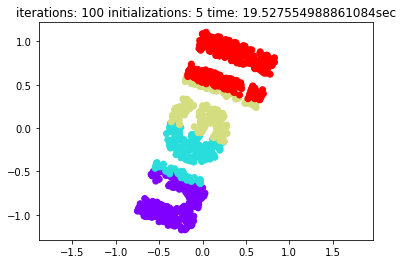

In [16]:
experiment(100,5)

We can observe that the result recovers a representation of the original data. This is essentially the goal of a manifold learning estimator: Given high-dimensional embedded data, it seeks a low dimensional representation of the data that preserves certain relationship within the data.

__Question 1 :__ Given the output above, which quantity or the relationship within the data is preserved?

### Non-linear embeddings: Where MDS Fails

Our discussion so far has considered linear embeddings, which essentially consist of rotations, translations, and scalings of data into higher-dimensional spaces. Where MDS breaks down is when the embedding is nonlinear—that is, when it goes beyond this simple set of operations. Consider the following embedding, which takes the input and contorts it into an "S" shape in three dimensions:

In [17]:
def make_data_s_curve(X):
    t = (X[:, 0] - 2) * 0.75 * np.pi
    x = np.sin(t)
    y = X[:, 1]
    z = np.sign(t) * (np.cos(t) - 1)
    return np.vstack((x, y, z)).T

XS = make_data_s_curve(X)

This is again three-dimensional data, but we can see that the embedding is much more complicated:

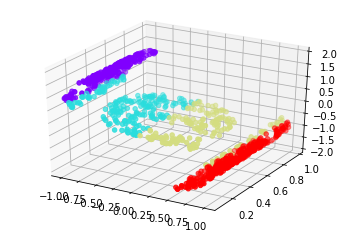

In [18]:
from mpl_toolkits import mplot3d

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(XS[:, 0], XS[:, 1], XS[:, 2],
             **colorize);

The fundamental relationships between the data points are still there, but this time the data has been transformed in a nonlinear way: it has been wrapped-up into the shape of an "S."

__Excercise :__ Pan and zoom the figure to see the charecteristics of the embedding. Check if you can see the word "CVIT".

Now, write the code to implement MDS such that it takes the input the above 3-dimensional embeddings and determine an optimal 2 dimensional embedding for the same.

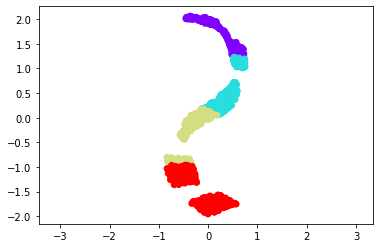

In [19]:
from sklearn.manifold import MDS
model = MDS(n_components=2, random_state=2, max_iter=100, n_init=5)
outS = model.fit_transform(XS)

fig = plt.figure()
plt.scatter(outS[:, 0], outS[:, 1], **colorize)
plt.axis('equal');

We observe that if we try the simple MDS algorithm on this data, it is not able to "unwrap" this nonlinear embedding, and we lose track of the fundamental relationships in the embedded manifold. The best 2-dimensional linear embedding does not unwrap the S-curve, but instead throws out the original y-axis.

__Question 2 :__ Why is MDS unable to unwrap the S-curve?

## 2. Locally Linear Embedding (LLE)

Locally linear embedding (LLE) is an intuitive approach based on the idea that small enough neighborhoods will represent patches lying along the manifold, which will then be approximately linear. By fitting locally along the manifold and learning the relationships defined by the intrinsic structure of the data, LLE can learn global, non-linear manifold geometries.

The idea behind the LLE approach is that we define data points in terms of their local linear relationships. We define data point $x_i$ as a linear combination of its local neighbors, and then we find a lower dimensional embedding that preserves these local linear relationships.

In MDS we have seen that it tries to preserve the distances between far away places. On the other hand, LLE tries to preserve distances only between nearby points. As an example, we can visualize the neighborhood or 'linkages' for the two algorithms below.

In [20]:
from mpl_toolkits.mplot3d.art3d import Line3DCollection
from sklearn.neighbors import NearestNeighbors


rng = np.random.RandomState(42)
ind = rng.permutation(len(X))

In [21]:
print(XS.shape)
print(len(X))
XS[ind[:100]].shape

(1000, 3)
1000


(100, 3)

In [22]:
# construct lines for MDS
lines_MDS = [(XS[i], XS[j]) for i in ind[:100] for j in ind[100:200]]

In [23]:
# construct lines for LLE
# kneighbors(self[, X, n_neighbors, …]) Finds the K-neighbors of a point
k = 100
nbrs = NearestNeighbors(n_neighbors=k).fit(XS).kneighbors(XS[ind[:100]])[1]
lines_LLE = [(XS[ind[i]], XS[j]) for i in range(100) for j in nbrs[i]]


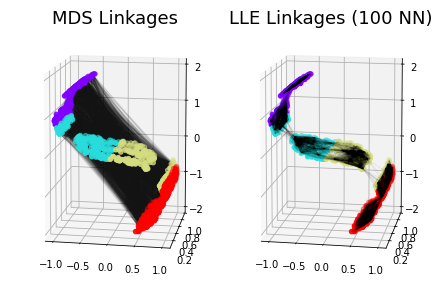

In [24]:
# plot the results
titles = ['MDS Linkages', 'LLE Linkages ({} NN)'.format(k)]
fig, ax = plt.subplots(1, 2, subplot_kw=dict(projection='3d', facecolor='none'))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0, wspace=0)

for axi, title, lines in zip(ax, titles, [lines_MDS, lines_LLE]):
    axi.scatter3D(XS[:, 0], XS[:, 1], XS[:, 2], **colorize);
    axi.add_collection(Line3DCollection(lines, lw=1, color='black',
                                        alpha=0.05))
    axi.view_init(elev=10, azim=-80)
    axi.set_title(title, size=18)

Here each faint line represents a distance that should be preserved in the embedding.  On the left is a representation of the model used by MDS: it tries to preserve the distances between each pair of points in the dataset. On the right is a representation of the model used by locally linear embedding (LLE): rather than preserving all distances, it instead tries to preserve only the distances between neighboring points: in this case, the nearest 100 neighbors of each point.

We will now use LLE algorithm to recover the embedded 2-dimensional manifold.

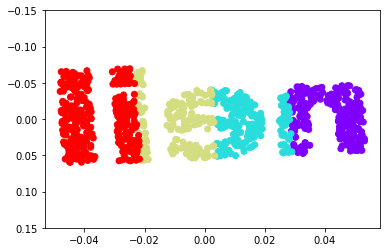

In [25]:
from sklearn.manifold import LocallyLinearEmbedding

# Define the model and train
model = LocallyLinearEmbedding(n_neighbors=k, n_components=2, method='modified', eigen_solver='auto')
out = model.fit_transform(XS)

# plot the result
fig, ax = plt.subplots()
ax.scatter(out[:, 0], out[:, 1], **colorize)
ax.set_ylim(0.15, -0.15);

The result captures the essential relationships in the data!

### Noisy Non-linear Embeddings: Where LLE Fails
Let us now see what happens when we add noise to our data. For this, we will first generate a noisy data below.

In [26]:
from mpl_toolkits import mplot3d

def getXS_noisy(X,mean,std):
    XS_noisy = make_data_s_curve(X,mean,std)
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    ax.scatter3D(XS_noisy[:, 0], XS_noisy[:, 1], XS_noisy[:, 2],
                 **colorize);
    return XS_noisy
def noisy_lle(X,mean,std):
    XS_noisy = getXS_noisy(X,mean,std)
    plot_XS_noisy(XS_noisy)
    
# generate noisy s-curve data
def make_data_s_curve(X,mean,std_dev):
    t = (X[:, 0] - 2) * 0.75 * np.pi
    x = np.sin(t) 
    y = X[:, 1] 
    z = np.sign(t) * (np.cos(t) - 1) + np.random.normal(mean, std_dev, t.shape)
    return np.vstack((x, y, z)).T

In [27]:
from sklearn.manifold import LocallyLinearEmbedding
def plot_XS_noisy(XS_noisy):
    # Define the model and train
    model = LocallyLinearEmbedding(n_neighbors=100, n_components=2, method='modified', eigen_solver='auto')
    out = model.fit_transform(XS_noisy)

    # plot the result
    fig, ax = plt.subplots()
    ax.scatter(out[:, 0], out[:, 1], **colorize)
    ax.set_ylim(0.15, -0.15);

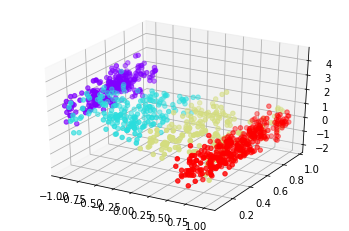

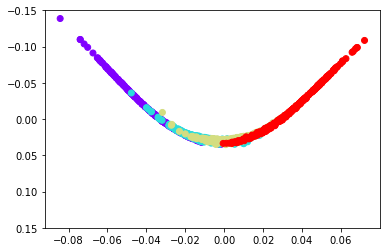

In [28]:
noisy_lle(X,1,.5)

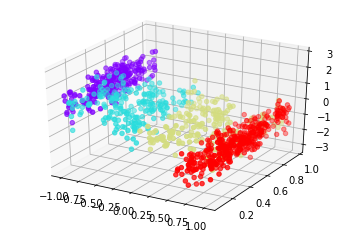

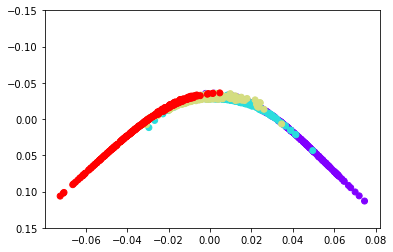

In [29]:
noisy_lle(X,0,.5)

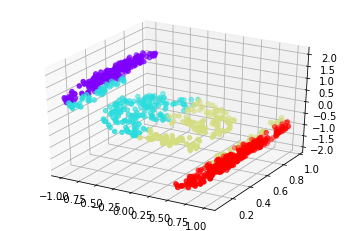

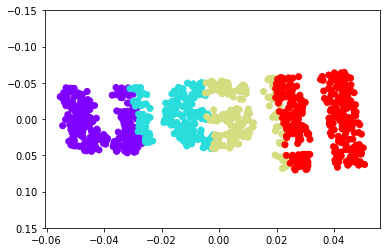

In [30]:
noisy_lle(X,0,.05)

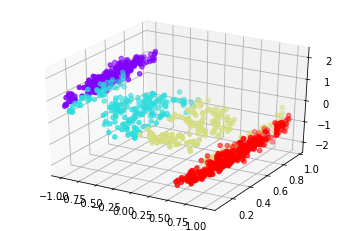

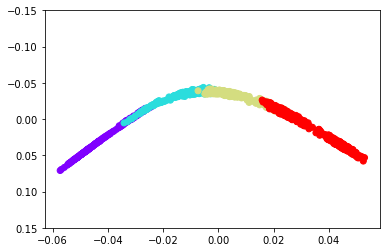

In [31]:
noisy_lle(X,0,.15)

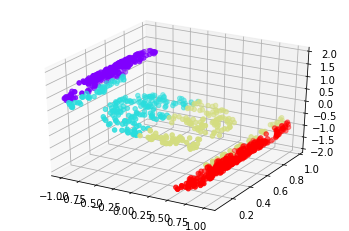

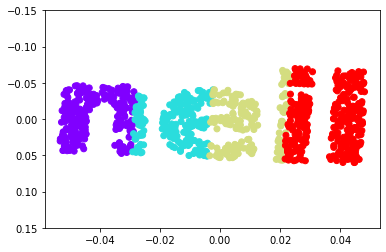

In [32]:
noisy_lle(X,0,.0005) #nice

We observe that by adding a small amount of noise to our non-linear mapping, LLE fails to properly recover our 2-dimensional embedding.

__Excercise :__ Run the experiment for different values of mean and standard deviation and see when LLE starts to fail.

__Question 3 :__ Why does LLE fails to recover in presence of noisy non-linear embeddings?

# 3. ISOMAPS

Isomap (Isometric mapping) is another one of the foundational algorithms in non-linear dimensionality reduction and manifold learning. Isomap introduces a unique approach to learning global geometric structure, which is based on representing high dimensional datasets with nearest neighbor graphs. The idea is that the distances you travel along the edges of the graph approximate distances along the manifold.

By learning the intrinsic metric defined along the manifold instead of the metric defined by an external coordinate system, isomap can learn highly complex, non-linear geometric relationships. Additionally, isomap then provides a lower dimensional embedding transformation that preserves the higher dimensional structure.

Before going into the details of the algorithm, we define two important concepts. Given two metric spaces $X$ and $Y$ with metrics $d_x$ and $d_y$, an Isometry is a bijective map $f : X \rightarrow Y$ between the two metric spaces that preserves distances:
$$
d_Y (f(a), f(b)) = d_X(a,b)
$$
In our case, we would like to find an isometric mapping from the manifold where the distance between data points $x_i$ and $x_j$ along the manifold (as the graph geodesic distance) is equal to the Euclidean distance between the corresponding lower dimensional output vectors $y_i$ and $y_j$.

For any general surface, a geodesic is a locally length minimizing path. Geodesics generalize the notion of straight-line shortest paths (in the Euclidean plane) to intrinsically defined surface geometries. In the isomap algorithm, we approximate the shortest path along the surface of the manifold by the graph geodesic - the minimally weighted path between two nodes.

In what follows, we will apply Isomaps to our non-linear embedding problem and see the result.

(1000, 3)


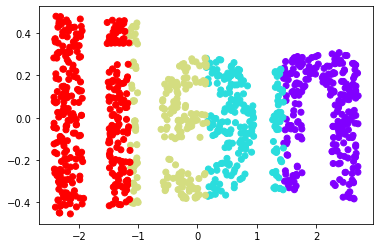

In [33]:
from sklearn.manifold import Isomap

# Define the model and train
model = Isomap(n_neighbors=200, n_components=3)
out = model.fit_transform(XS)
print(out.shape)

# plot the result
fig, ax = plt.subplots()
ax.scatter(out[:, 0], out[:, 1], **colorize)

In [34]:
print(model.reconstruction_error())

0.005624263106116376


Like LLE, ISOMAP successfully recovers the structure of the 2-dimensional embedding. ISOMAP has the basic idea of preserving geodesic distance as measured along the manifold, hence can flatten (unroll) the swiss roll. 

Let us test ISOMAP on the noisy non-linear embedding and see its output.

In [35]:
from sklearn.manifold import Isomap
def noisy_isomap(X,mean,std,k):
    XS_noisy = getXS_noisy(X,mean,std)
    # Define the model and train
    model = Isomap(n_neighbors=k, n_components=2)
    out = model.fit_transform(XS_noisy)
    print(out.shape)

# plot the result
    fig, ax = plt.subplots()
    ax.scatter(out[:, 0], out[:, 1], **colorize)

(1000, 2)


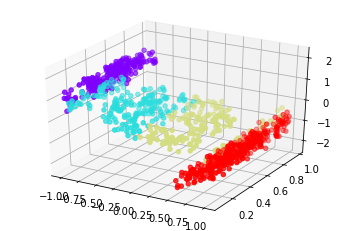

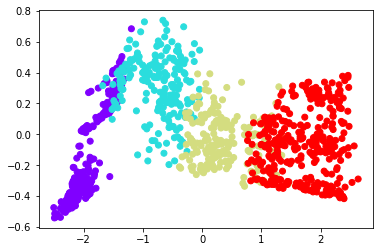

In [36]:
 noisy_isomap(X,0,0.2,100)

(1000, 2)


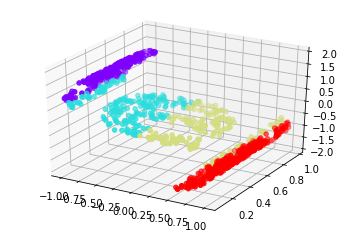

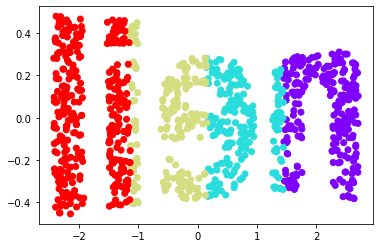

In [37]:
 noisy_isomap(X,0,0.001,200)

(1000, 2)


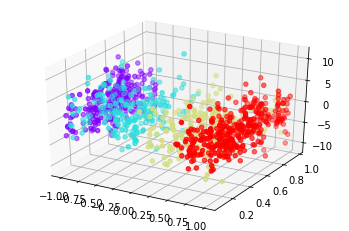

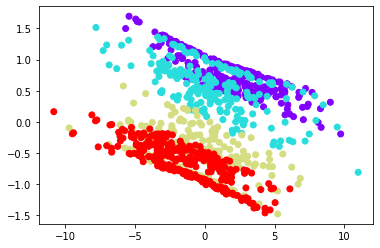

In [38]:
 noisy_isomap(X,0,3,100)

(1000, 2)


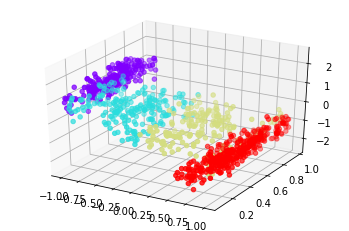

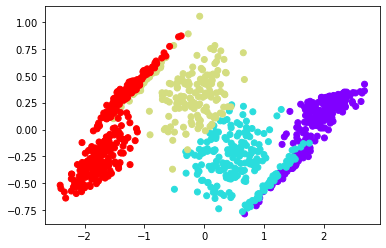

In [39]:
 noisy_isomap(X,0,0.3,100)

We observe that ISOMAP successfully recovers the 2-dimensional embedding even in the presence of noise.

__Excercise :__ Change the number of neighbors `n_neighbors` of the ISOMAP and check the robustness of the method.

__Question 4:__ Why ISOMAP is able to recover the structure even in presence of noise, given suitable hyper-parameters?

__Excercise :__ Change the standard deviation of the Guassian noise added to the data and check for robustness of the method.

__Question 5:__ Why is ISOMAP robust/not-robust with respect to the `n_neighbors` hyper-parameters.

# 4. t-SNE

t-Distributed Stochastic Neighbor Embedding (t-SNE) is a non-linear technique for dimensionality reduction that is particularly well suited for the visualization of high-dimensional datasets. It is extensively applied in image processing, NLP, genomic data and speech processing. To keep things simple, here’s a brief overview of working of t-SNE:

- The algorithms starts by calculating the probability of similarity of points in high-dimensional space and calculating the probability of similarity of points in the corresponding low-dimensional space. The similarity of points is calculated as the conditional probability that a point A would choose point B as its neighbor if neighbors were picked in proportion to their probability density under a Gaussian (normal distribution) centered at A.

- It then tries to minimize the difference between these conditional probabilities (or similarities) in higher-dimensional and lower-dimensional space for a perfect representation of data points in lower-dimensional space.

- To measure the minimization of the sum of difference of conditional probability t-SNE minimizes the sum of Kullback-Leibler (KL-) divergence of overall data points using a gradient descent method.

Let us see the effect of applying t-SNE to our problem.

(1000, 2)


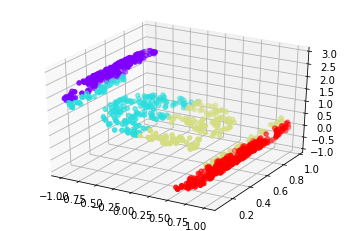

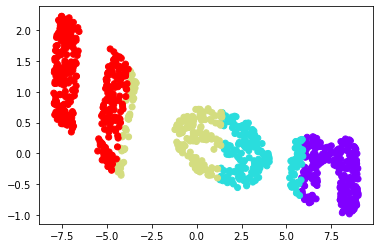

In [42]:
from sklearn.manifold import TSNE

# Define the model and train
model =  TSNE(n_components=2, perplexity=300.0)
out = model.fit_transform(getXS_noisy(X,1,0))
print(out.shape)

# plot the result
fig, ax = plt.subplots()
ax.scatter(out[:, 0], out[:, 1], **colorize)

t-SNE is able to recover the 2-dimensional embedding. 

Let us now check it on __noisy data__.

(1000, 2)


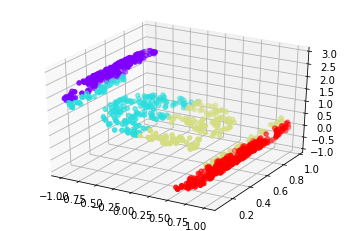

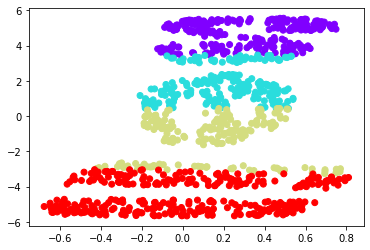

In [43]:
from sklearn.manifold import TSNE

# Define the model and train
model =  TSNE(n_components=2, perplexity=400.0)
out = model.fit_transform(getXS_noisy(X,1,0))
print(out.shape)

# plot the result
fig, ax = plt.subplots()
ax.scatter(out[:, 0], out[:, 1], **colorize)

No surprises here! t-SNE works here too.

__Excercise :__ Change the `perplexity` hyperparameter values and check for robustness.

__Excercise :__ Change the standard deviation of the Guassian noise added to the data and check the rboustness of the method with respect to the `perplexity` hyperparameter.

__Question 6 :__ What is the `perplexity` hyperparameter? Why selecting a different value results in significantly different results

# 5. Spectral Embedding / Laplacian Eigenmaps


First, we begin with a restatement of the manifold learning setting: assume we have data $x_{1}, x_{2}, \cdots, x_{n} \in \mathbb{R}^{N}$ that are sampled from an unknown manifold $M \subset \mathbb{R}^{N}$. Our goal is to construct a lower dimensional embedding of the data, where we find a transformation of the original data to the corresponding lower dimensional points $y_{1}, y_{2}, \cdots, y_{n} \in \mathbb{R}^{m}$ with $m \lt N$.

We first attempt to model the continuous, underlying manifold by constructing a graph $G = (V, E)$ out of the discrete data points. We let the data points $x_{1}, x_{2}, \cdots, x_{n}$ be the nodes of our graph, and we connect neighboring points with edges. This graph will then contain information about the structure of the manifold. The local relationships and intrinsic geometry of the manifold are reflected in the graph edges, which are given weights that indicate similarity between data points.

So far this is very similar to other manifold learning algorithms, where the manifold is first assumed and the neighborhood graph is constructed. The distinguishing aspect of Laplacian Eigenmaps/Spectral Embedding is the use of the Laplacian Matrix (or Graph/Discrete Laplacian), a discrete analog of the Laplacian operator. We use the eigenvalue decomposition of the Laplacian Matrix $L$, and by utilizing some of the associated properties of the Laplacian Matrix, we are able to find an optimal, lower dimensional embedding that preserves the assumed manifold structure of the data.

The Spectral Embedding (Laplacian Eigenmaps) algorithm comprises three stages:
1. kNN graph: construct nearest neighbors graph and the adjacency matrix $W \in \mathbb{R}^{n \times n}$
2. Graph Laplacian (Laplacian Matrix): use degree matrix $D$ and adjacency matrix to compute the Laplacian $\mathbf{L} = D - W$
3. Eigenvector Embedding: use the first m eigenvectors $f_1, ..., f_m$ (with the m smallest nonzero eigenvalues) of the Laplacian matrix to map each $x_i$ to lower dimensional vectors $y_i \in \mathbb{R}^m$

Let's apply this algorithm to our data.

### Excercise: Apply Spectral Embedding for noisy and non-noisy embeddings. Play with the hyperparameters and observe the outputs.

In [ ]:
'''
For non-noisy embedding $XS$
'''
from sklearn.manifold import SpectralEmbedding

# Define the model and train
##### YOUR CODE HERE #####

# plot the result
fig, ax = plt.subplots()
ax.scatter(out[:, 0], out[:, 1], **colorize)

In [ ]:
'''
For noisy embeddings $XS_noisy$
'''

from sklearn.manifold import SpectralEmbedding

# Define the model and train
##### YOUR CODE HERE #####

# plot the result
fig, ax = plt.subplots()
ax.scatter(out[:, 0], out[:, 1], **colorize)

In [ ]:
# X_equi = np.linspace(0,2000,num=1000)
X_equi = np.random.rand(1000)
# print(len(X_equi))
y = np.zeros(len(X_equi))
X_f = np.vstack([y, X_equi]).T
print(X_f.shape)
print(X_f)
# print(X_equi)
plt.plot(X_f[:,0], X_f[:,1], 'o')
X20 = random_projection(X_f, 20)
print(X20.shape)
print(X20)

In [ ]:
# Define the model and train
k = 2
model = Isomap(n_neighbors=k, n_components=1)
out = model.fit_transform(X20)
print(out.shape)
z = np.zeros(len(out))
# plot the result
fig, ax = plt.subplots()
ax.scatter(out, y, **colorize)

In [ ]:
k = 5
model = Isomap(n_neighbors=k, n_components=1)
out = model.fit_transform(X20)
print(out.shape)
z = np.zeros(len(out))
# plot the result
fig, ax = plt.subplots()
ax.scatter(out, y, **colorize)

In [ ]:
k = 10
model = Isomap(n_neighbors=k, n_components=1)
out = model.fit_transform(X20)
print(out.shape)
z = np.zeros(len(out))
# plot the result
fig, ax = plt.subplots()
ax.scatter(out, y, **colorize)